### Import packages

In [23]:
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

# 1. Example match
Data taken from https://www.oddsportal.com/basketball/usa/nba/houston-rockets-golden-state-warriors-lMlLpR7P/

In [67]:
df_example = pd.read_csv("example_game.csv", index_col=0)
df_example['Time'] = pd.to_datetime(df_example['Time'])
df_example = df_example.rename(columns={"Type": "Team name"})
# df_example["Team name"] = df_example["Team name"].map({'away': "Golden State Warriors",
#                                                        'home': "Houston Rockets"})
df_example.head()

,Time,Book_n,Coef,Team name
0,2018-11-16 01:39:00,10Bet,1.59,home
1,2018-11-15 20:06:00,10Bet,1.63,home
2,2018-11-15 19:15:00,10Bet,1.67,home
3,2018-11-15 18:06:00,10Bet,1.65,home
4,2018-11-15 16:03:00,10Bet,1.73,home


In [51]:
# df_example.sort_values("Time", ascending=True)

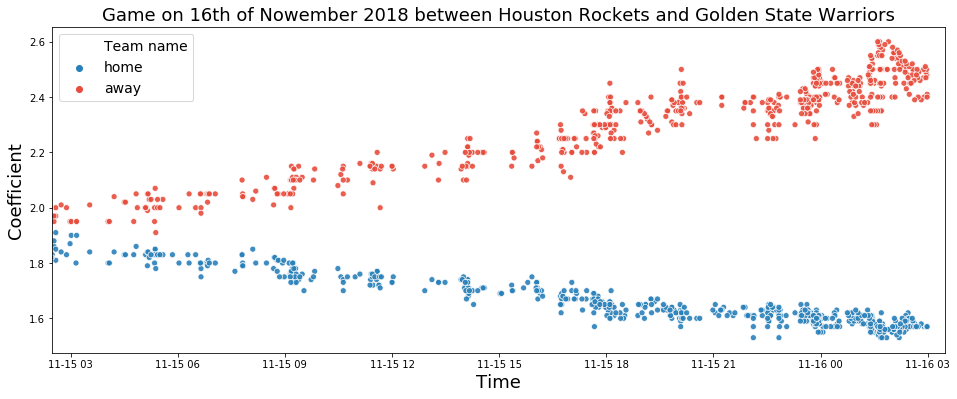

In [141]:
x_min = df_example.Time.max() - datetime.timedelta(hours=24.5)
x_max = df_example.Time.max() + datetime.timedelta(hours=0.5)
plt.figure(figsize=(16, 6))
# dict(home="#e74c3c", away="#2980b9")
ax = sns.scatterplot(x="Time", y="Coef", hue="Team name", data=df_example,
                     palette=dict(home="#2980b9", away="#e74c3c"), alpha=0.9)
ax.set_title("Game on 16th of Nowember 2018 between Houston Rockets and Golden State Warriors",
            fontsize=18)
ax.set_ylabel("Coefficient",fontsize=18)
ax.set_xlabel("Time", fontsize=18)
ax.set_xlim(x_min, x_max)
plt.legend(fontsize=14)
plt.savefig("images/example_game_time.png", dpi=200, format="png");

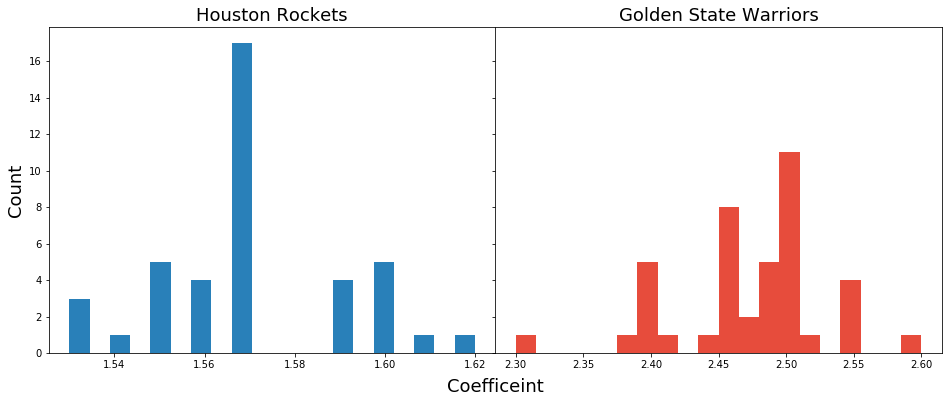

In [136]:
# process results
home_last = df_example[df_example["Team name"]=="home"].groupby('Book_n')["Coef"].first()
away_last = df_example[df_example["Team name"]=="away"].groupby('Book_n')["Coef"].first()
# plot results
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,6))
ax1.hist(home_last.values, bins=20, color="#2980b9")
ax1.set_ylabel("Count", fontsize=18)
ax1.set_title("Houston Rockets", fontsize=18)
ax2.hist(away_last.values, bins=20, color="#e74c3c")
ax2.set_title("Golden State Warriors", fontsize=18)
f.subplots_adjust(wspace=0)
ax2.set_xlabel("Coefficeint", fontsize=18);
ax2.xaxis.set_label_coords(0, -0.075);
plt.savefig("images/example_game_last_coeff.png", dpi=200, format="png");

# 2. Basketball analysis

### Load DataFrame check for NAN values (drop NAN rows)

In [58]:
df = pd.read_csv("basketball_scores.csv", index_col=0)
df.head()

,League,Season,Home_score,Away_score,Win,OT,Home_p,Away_p,URL
0,NBA,2017/2018,85.0,108.0,0.0,0.0,2.55,1.68,https://www.oddsportal.com/basketball/usa/nba-...
1,NBA,2017/2018,102.0,110.0,0.0,0.0,2.35,1.75,https://www.oddsportal.com/basketball/usa/nba-...
2,NBA,2017/2018,122.0,103.0,1.0,0.0,1.23,5.80,https://www.oddsportal.com/basketball/usa/nba-...
3,NBA,2017/2018,124.0,114.0,1.0,1.0,1.14,8.16,https://www.oddsportal.com/basketball/usa/nba-...
4,NBA,2017/2018,92.0,101.0,0.0,0.0,3.50,1.40,https://www.oddsportal.com/basketball/usa/nba-...


In [59]:
df.isna().sum()

League        0
Season        0
Home_score    1
Away_score    1
Win           1
OT            1
Home_p        0
Away_p        0
URL           0
dtype: int64

In [60]:
# Drop missing values
df = df.dropna()

### Calculate implied propabilities and absolute difference between propabilities
* Implied propability is inverse of european coefficient.
* Create separate DataFrames or each league.

In [61]:
df["Home_prop"] = 1/df["Home_p"]
df["Away_prop"] = 1/df["Away_p"]
df["Diff_prop"] = abs(df["Home_prop"] - df["Away_prop"])
df.head()

,League,Season,Home_score,Away_score,Win,OT,Home_p,Away_p,URL,Home_prop,Away_prop,Diff_prop
0,NBA,2017/2018,85.0,108.0,0.0,0.0,2.55,1.68,https://www.oddsportal.com/basketball/usa/nba-...,0.392157,0.595238,0.203081
1,NBA,2017/2018,102.0,110.0,0.0,0.0,2.35,1.75,https://www.oddsportal.com/basketball/usa/nba-...,0.425532,0.571429,0.145897
2,NBA,2017/2018,122.0,103.0,1.0,0.0,1.23,5.80,https://www.oddsportal.com/basketball/usa/nba-...,0.813008,0.172414,0.640594
3,NBA,2017/2018,124.0,114.0,1.0,1.0,1.14,8.16,https://www.oddsportal.com/basketball/usa/nba-...,0.877193,0.122549,0.754644
4,NBA,2017/2018,92.0,101.0,0.0,0.0,3.50,1.40,https://www.oddsportal.com/basketball/usa/nba-...,0.285714,0.714286,0.428571


## Compare League competiveness

In [62]:
# Absolute difference between home and away team win propabilities
df.groupby(["League", "Season"])["Diff_prop"].mean()

League  Season   
EURO    2013/2014    0.471486
        2014/2015    0.462334
        2015/2016    0.412284
        2016/2017    0.381262
        2017/2018    0.393321
NBA     2013/2014    0.376663
        2014/2015    0.419817
        2015/2016    0.391015
        2016/2017    0.376579
        2017/2018    0.367236
Name: Diff_prop, dtype: float64

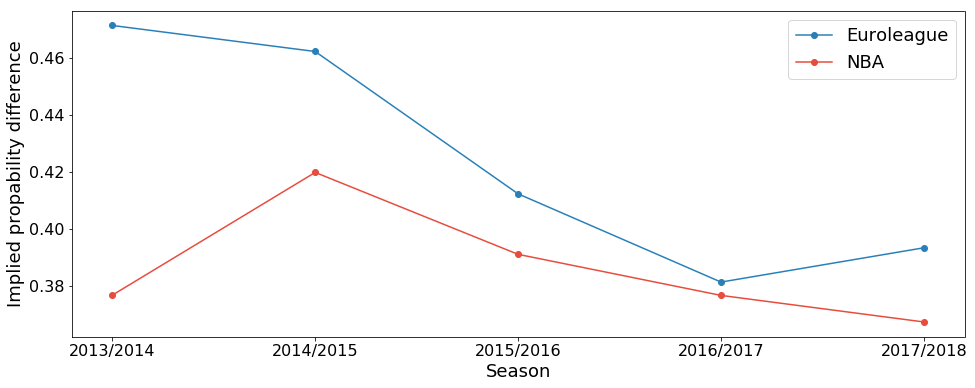

In [64]:
# create separate DataFrames for NBA and Euroleague
df_euro = df[df.League == 'EURO']
df_nba = df[df.League == 'NBA']
# get mean difference between propabilities
diff_euro = df_euro.groupby(['Season'])['Diff_prop'].mean()
diff_nba = df_nba.groupby(['Season'])['Diff_prop'].mean()
# plot results
plt.figure(figsize=(16,6))
plt.tick_params(axis='both', which='major', labelsize=16)
plt.plot(diff_euro.index, diff_euro.values, "o-", color="#2980b9", label="Euroleague")
plt.plot(diff_euro.index, diff_nba.values, "o-", color="#e74c3c", label="NBA")
plt.xlabel("Season", fontsize=18)
# plt.yticks([0.38, 0.4, 0.42, 0.44])
plt.ylabel("Implied propability difference", fontsize=18)
plt.legend(fontsize=18)
plt.savefig("images/implied_prop.png", dpi=200, format="png")

### How common are over times

In [8]:
# Total points
df.groupby(["League", "Season"])["OT"].mean()

League  Season   
EURO    2013/2014    0.063333
        2014/2015    0.033333
        2015/2016    0.040000
        2016/2017    0.056667
        2017/2018    0.096667
NBA     2013/2014    0.061422
        2014/2015    0.066207
        2015/2016    0.069655
        2016/2017    0.054483
        2017/2018    0.056429
Name: OT, dtype: float64

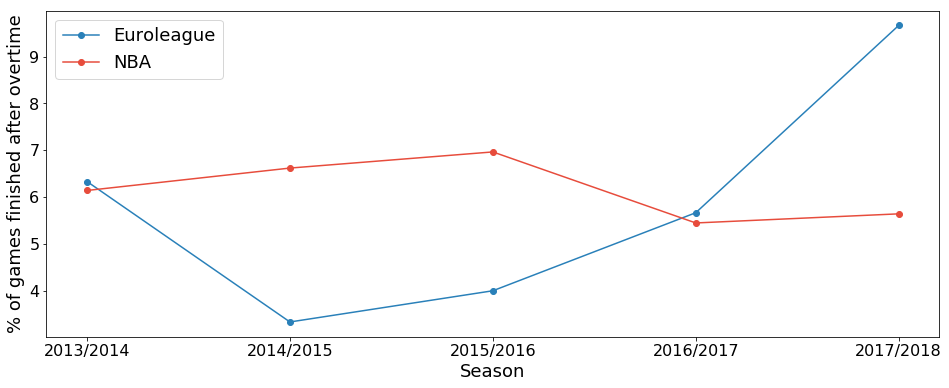

In [106]:
# get season names
seasons = df_euro.Season.unique()[::-1]
# get mean difference between propabilities
ot_euro = df_euro.groupby(['Season'])['OT'].mean() * 100
ot_nba = df_nba.groupby(['Season'])['OT'].mean() * 100
# plot results
plt.figure(figsize=(16,6))
plt.tick_params(axis='both', which='major', labelsize=16)
plt.plot(ot_euro.index, ot_euro.values, "o-", color="#2980b9", label="Euroleague")
plt.plot(ot_nba.index, ot_nba.values, "o-", color="#e74c3c", label="NBA")
plt.xlabel("Season", fontsize=18)
# plt.yticks([4, 5, 6, 7])
plt.ylabel("% of games finished after overtime", fontsize=18)
plt.legend(fontsize=18)
plt.savefig("images/ot_games.png", dpi=200, format="png")

## Total scored points per game

In [97]:
# Total points
df['Total'] = df["Away_score"] + df["Home_score"]
df.groupby(["League", "Season"])["Total"].mean()

League  Season   
EURO    2013/2014    151.433333
        2014/2015    155.106667
        2015/2016    155.368000
        2016/2017    157.300000
        2017/2018    165.843333
NBA     2013/2014    202.319531
        2014/2015    199.659310
        2015/2016    205.117931
        2016/2017    212.217931
        2017/2018    212.861429
Name: Total, dtype: float64

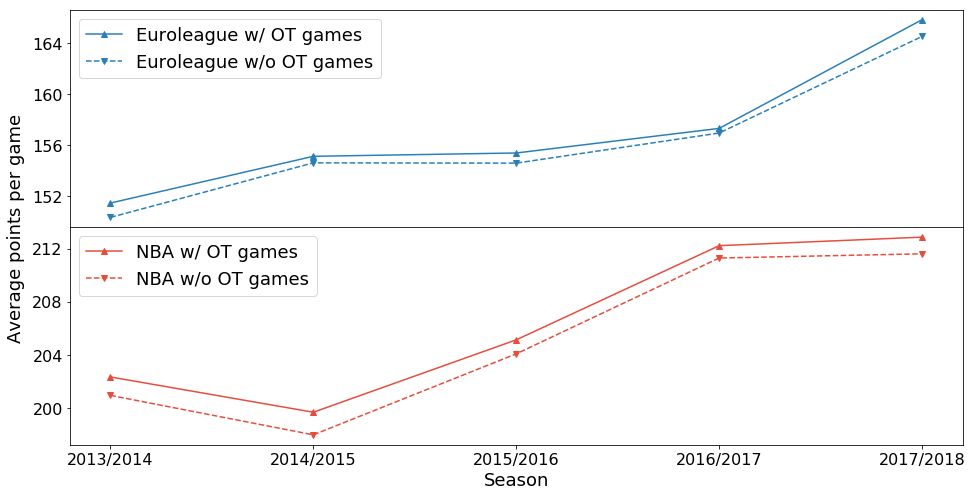

In [98]:
# update NBA and Euroleague DataFrames
df_euro = df[df.League == 'EURO']
df_nba = df[df.League == 'NBA']
# total scored points including games finished with overtime
total_euro = df_euro.groupby(['Season'])['Total'].mean()
total_nba = df_nba.groupby(['Season'])['Total'].mean()
# total scored points excluding games finished with overtime
total_ot_euro = df_euro[df_euro.OT!=1].groupby(['Season'])['Total'].mean()
total_ot_nba = df_nba[df_nba.OT!=1].groupby(['Season'])['Total'].mean()
# plot results
f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(16,8))
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.plot(total_euro.index, total_euro.values, "^-", color="#2980b9", label="Euroleague w/ OT games")
ax1.plot(total_ot_euro.index, total_ot_euro.values, "v--", color="#2980b9", label="Euroleague w/o OT games")
ax1.legend(fontsize=18)
ax1.set_yticks([152, 156, 160, 164])
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.plot(total_nba.index, total_nba.values, "^-", color="#e74c3c", label="NBA w/ OT games")
ax2.plot(total_ot_nba.index, total_ot_nba.values, "v--", color="#e74c3c", label="NBA w/o OT games")
ax2.legend(fontsize=18)
ax2.set_yticks([200, 204, 208, 212])
ax2.set_xlabel("Season", fontsize=18)
ax2.set_ylabel("Average points per game", fontsize=18)
ax2.xaxis.set_label_coords(0.5, -0.12)
ax2.yaxis.set_label_coords(-0.05, 1.0)
f.subplots_adjust(hspace=0)
plt.savefig("images/total_points.png", dpi=200, format="png")

## Home court advantage

In [99]:
df.groupby(["League", "Season"])["Win"].mean()

League  Season   
EURO    2013/2014    0.670000
        2014/2015    0.626667
        2015/2016    0.660000
        2016/2017    0.556667
        2017/2018    0.593333
NBA     2013/2014    0.601104
        2014/2015    0.577931
        2015/2016    0.604828
        2016/2017    0.591034
        2017/2018    0.605714
Name: Win, dtype: float64

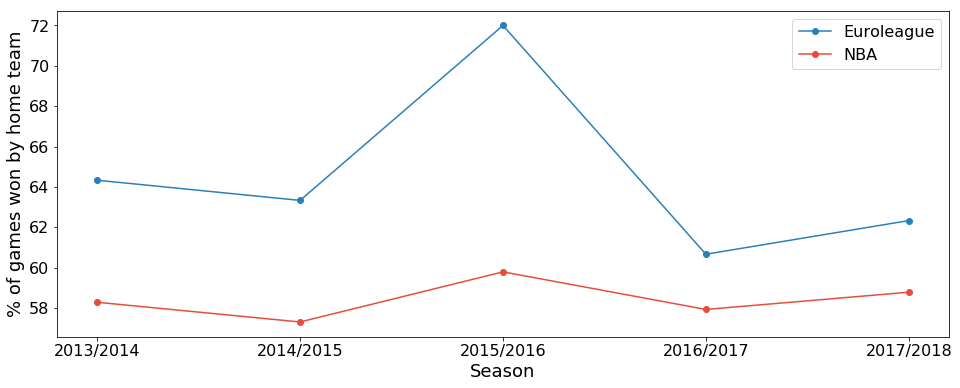

In [21]:
# home team wins
home_w_euro = df_euro.groupby(['Season'])['Win'].mean() * 100
home_w_nba = df_nba.groupby(['Season'])['Win'].mean() * 100
# plot results
plt.figure(figsize=(16,6))
plt.tick_params(axis='both', which='major', labelsize=16)
plt.plot(home_w_euro.index, home_w_euro.values, "o-", color="#2980b9", label="Euroleague")
plt.plot(home_w_euro.index, home_w_nba.values, "o-", color="#e74c3c", label="NBA")
plt.xlabel("Season", fontsize=18)
plt.ylabel("% of games won by home team", fontsize=18)
plt.legend(fontsize=16)
plt.savefig("images/home_victories.png", dpi=200, format="png")

## Profitable strategies

In [ ]:
# create new columns indicating whatever home or away team won
df_win = pd.concat([df, pd.get_dummies(df['Win']).rename(columns={0.0:"Away_win", 1.0:"Home_win"})], axis=1)
df_win.head()

### 1. bet only on home team or on away team

In [93]:
df_win["All_home"] = (df_win.Home_p-1)*df_win.Home_win - df_win.Away_win
df_win.groupby(["League", "Season"])["All_home"].sum() / df_win.groupby(["League", "Season"])["All_home"].count()

NameError: name 'df_win' is not defined

In [94]:
df_win["All_away"] = (df_win.Away_p-1)*df_win.Away_win - df_win.Home_win
df_win.groupby(["League", "Season"])["All_away"].sum() / df_win.groupby(["League", "Season"])["All_away"].count()

NameError: name 'df_win' is not defined

In [95]:
# calculate win precentage of bet only home or only away
df_win_euro = df_win[df_win.League == "EURO"].copy()
df_win_euro_h = df_win_euro.groupby(['Season'])["All_home"].sum() / df_win_euro.groupby(['Season'])["All_home"].count()
df_win_euro_a = df_win_euro.groupby(['Season'])["All_away"].sum() / df_win_euro.groupby(['Season'])["All_away"].count()
df_win_nba = df_win[df_win.League == "NBA"].copy()
df_win_nba_h = df_win_nba.groupby(['Season'])["All_home"].sum() / df_win_nba.groupby(['Season'])["All_home"].count()
df_win_nba_a = df_win_nba.groupby(['Season'])["All_away"].sum() / df_win_nba.groupby(['Season'])["All_away"].count()

# plot results
f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(16,8))
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.plot(seasons, df_win_euro_h*100, "^-", color="#2980b9", label="Euroleague (bet only home)")
ax1.plot(seasons, df_win_euro_a*100, "v--", color="#2980b9", label="Euroleague (bet only away)")
ax1.legend(fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.plot(seasons, df_win_nba_h*100, "^-", color="#e74c3c", label="NBA (bet only home)")
ax2.plot(seasons, df_win_nba_a*100, "v--", color="#e74c3c", label="NBA (bet only away)")
ax2.legend(fontsize=16)
ax2.set_xlabel("Season", fontsize=18)
ax2.set_ylabel("ROI (%)", fontsize=18)
ax2.xaxis.set_label_coords(0.5, -0.12)
ax2.yaxis.set_label_coords(-0.05, 1.0)
f.subplots_adjust(hspace=0)
plt.savefig("bet_strat_1.png", dpi=200, format="png")

NameError: name 'df_win' is not defined

### 2. bet only on home favourite or home long shot

In [ ]:
# take rows where home coefficient is lower than away teams
df_win_home_fav = df_win[df_win.Home_p < df_win.Away_p]
df_win_home_fav.groupby(["League", "Season"])["All_away"].sum() / df_win.groupby(["League", "Season"])["All_away"].count()

In [ ]:
# take rows where home coefficient is larger than 3.0
df_win_home_long = df_win[df_win.Home_p > 3.0]
df_win_home_long.groupby(["League", "Season"])["All_away"].sum() / df_win.groupby(["League", "Season"])["All_away"].count()

In [ ]:
# calculate win precentage of betting only on home favourite
df_win_euro_f = df_win_home_fav[df_win_home_fav.League == "EURO"].copy()
df_win_euro_h_f = df_win_euro_f.groupby(['Season'])["All_home"].sum() / df_win_euro_f.groupby(['Season'])["All_home"].count()
df_win_euro_l = df_win_home_long[df_win_home_long.League == "EURO"].copy()
df_win_euro_h_l = df_win_euro_l.groupby(['Season'])["All_home"].sum() / df_win_euro_l.groupby(['Season'])["All_home"].count()
# df_win_euro_a = df_win_euro.groupby(['Season'])["All_away"].sum() / df_win_euro.groupby(['Season'])["All_away"].count()
df_win_nba_f = df_win_home_fav[df_win_home_fav.League == "NBA"].copy()
df_win_nba_h_f = df_win_nba_f.groupby(['Season'])["All_home"].sum() / df_win_nba_f.groupby(['Season'])["All_home"].count()
df_win_nba_l = df_win_home_long[df_win_home_long.League == "NBA"].copy()
df_win_nba_h_l = df_win_nba_l.groupby(['Season'])["All_home"].sum() / df_win_nba_l.groupby(['Season'])["All_home"].count()

# plot results
f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(16,8))
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.plot(seasons, df_win_euro_h_f*100, "^-", color="#2980b9", label="Euroleague (home favourite)")
ax1.plot(seasons, df_win_euro_h_l*100, "v--", color="#2980b9", label="Euroleague (home long shot)")
ax1.legend(fontsize=16, loc=2)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.plot(seasons, df_win_nba_h_f*100, "^-", color="#e74c3c", label="NBA (home favourite)")
ax2.plot(seasons, df_win_nba_h_l*100, "v--", color="#e74c3c", label="NBA (home long shot)")
ax2.legend(fontsize=16)
ax2.set_xlabel("Season", fontsize=16)
ax2.set_ylabel("ROI (%)", fontsize=16)
ax2.xaxis.set_label_coords(0.5, -0.12)
ax2.yaxis.set_label_coords(-0.05, 1.0)
f.subplots_adjust(hspace=0)
plt.savefig("bet_strat_2.png", dpi=200, format="png")